# English to Urdu Machine Translation using Attention and GRUs

In this notebook, you will learn how to perform english to urdu translation using:
- GRUs as RNNs
- Encoder-Decoder Architecture
- Attention
- Custom TF2 training loops
- Evaluating Machine Translation models with Attention Heatmaps

In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
from pathlib import Path

## Load and Preprocess Data

In [329]:
path = Path("DIRECTORY")/"urd.txt" #change as needed

In [330]:
io.open(path, encoding='UTF-8').read().strip().split('\n')[:2]

['Help!\tمدد۔\tCC-BY 2.0 (France) Attribution: tatoeba.org #435084 (lukaszpp) & #1462368 (nabeel_tahir)',
 'We won.\tہم جیت گئے۔\tCC-BY 2.0 (France) Attribution: tatoeba.org #2107675 (CK) & #2123755 (nabeel_tahir)']

In [331]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

In [332]:
def preprocess_sentence(s):
    s = unicode_to_ascii(s.lower().strip())
    
    #Add space before any punctuation
    s = re.sub(r"([?.!,¿])", r" \1 ", s)
    
    #Remove several spaces with a single space
    s = re.sub(r'[" "]+', " ", s)
       
    return "<start> " + s.strip() + " <end>"

In [333]:
def parse_file(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    
    word_pairs = [[preprocess_sentence(s) for s in line.split('\t')[:2]] for line in lines[:num_examples]]
    
    return zip(*word_pairs)

In [334]:
def tokenize(sentences):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(sentences)
    
    tensor = tokenizer.texts_to_sequences(sentences)
    
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor, tokenizer

In [335]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [336]:
def load_data(path, num_examples=None):
    inp_sentences, targ_sentences = parse_file(path, num_examples)
    
    inp_tensors, inp_lang_tokenizer = tokenize(inp_sentences)
    targ_tensors, targ_lang_tokenizer = tokenize(targ_sentences)
    
    return inp_tensors, targ_tensors, inp_lang_tokenizer, targ_lang_tokenizer

In [337]:
en, urd = parse_file(path, None)
print(en[-1])
print(urd[-1])

<start> when you meet someone for the first time , be careful about how close you stand to that person . <end>
<start> جب تم پہلی دفعہ کسی سے ملو، اس بات کو مد نظر رکھو کہ تم اس کے کتنا قریب کھڑے ہو۔ <end>


In [338]:
# Try experimenting with the size of that dataset
num_examples = None
input_tensor, target_tensor, inp_lang, targ_lang = load_data(path, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [339]:
def convert(lang, tensor):
    for word in tensor:
        if word != 0:
            print(f"{word} -----> {lang.index_word[word]}")

In [340]:
convert(inp_lang, input_tensor[0])

1 -----> <start>
208 -----> help
178 -----> !
2 -----> <end>


In [341]:
convert(targ_lang, target_tensor[0])

1 -----> <start>
837 -----> مدد۔
2 -----> <end>


In [342]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

In [343]:
len(target_tensor_train)

932

### Create a tf.data Dataset

In [344]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
STEPS_PER_EPOCH = len(input_tensor_train) // BATCH_SIZE
vocab_inp_size = len(inp_lang.word_index) + 1
vocab_targ_size = len(targ_lang.word_index) + 1

In [345]:
train_data = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
train_data = train_data.batch(BATCH_SIZE)

In [346]:
example_input_batch, example_target_batch = next(iter(train_data))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 22]), TensorShape([64, 23]))

## Implementing the Encoder and Decoder model with Attention

In [347]:
embedding_dim = 512
gru_units = 512

In [349]:
def Encoder(input_dim, embedding_dim, gru_units, batch_size):
    
    input = tf.keras.layers.Input(shape=(None,))
    hidden = tf.keras.layers.Input(shape=((gru_units,)), batch_size=batch_size)
    
    embed = tf.keras.layers.Embedding(input_dim, embedding_dim)
    
    gru = tf.keras.layers.GRU(gru_units,
                              return_sequences=True,
                              return_state=True,
                              recurrent_initializer='glorot_uniform'
                              )
    
    x = embed(input)
    out, state = gru(x, initial_state=hidden)
    
    return tf.keras.Model(inputs=(input, hidden), outputs=(out, state))

In [350]:
def init_hidden(batch_size, gru_units):
    return tf.zeros(shape=((batch_size, gru_units)))

In [351]:
encoder = Encoder(vocab_inp_size, embedding_dim, gru_units, BATCH_SIZE)

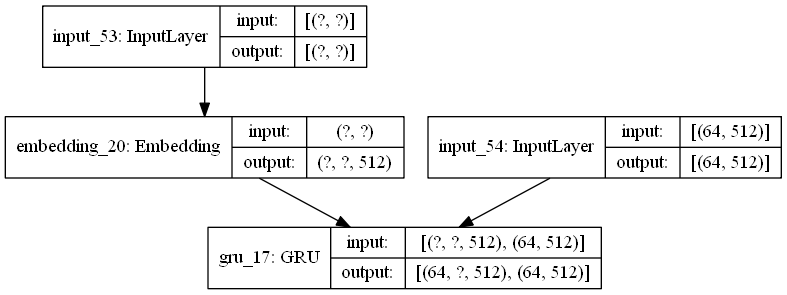

In [352]:
tf.keras.utils.plot_model(encoder, show_shapes=True)

In [353]:
example_input_batch.shape

TensorShape([64, 22])

In [354]:
sample_hidden = init_hidden(BATCH_SIZE, gru_units)

sample_output, sample_hidden = encoder((example_input_batch, sample_hidden))

print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 22, 512)
Encoder Hidden state shape: (batch size, units) (64, 512)


In [356]:
def BahdanauAttention(query, values, units):
    #query tensor shape: (batch_size, hidden_dim)
    #values tensor shape: (batch_size, max_len, hidden_dim)
    
    W1 = tf.keras.layers.Dense(units)
    W2 = tf.keras.layers.Dense(units)
    V = tf.keras.layers.Dense(1)

    query_with_time_axis = tf.expand_dims(query, axis=1) #(B, 1, H)
    
    #(B, max_len, 1)
    scores = V(tf.nn.tanh(
        W1(query_with_time_axis) + W2(values)))
    
    attention_weights = tf.nn.softmax(scores, axis=1)#(B, max_len, 1)
    
    context_vector = attention_weights * values #(B, max_len, H)
    context_vector = tf.reduce_sum(context_vector, axis=1, keepdims=False) #(B, H)
    
    return context_vector, attention_weights

In [357]:
def Decoder(vocab_size, emb_dim, enc_units, dec_units):
    input = tf.keras.layers.Input(shape=(None, ))
    hidden = tf.keras.layers.Input(shape=(enc_units, ))
    enc_output = tf.keras.layers.Input(shape=(None, enc_units))
    
    embedding = tf.keras.layers.Embedding(vocab_size, emb_dim)
    gru = tf.keras.layers.GRU(dec_units,
                              return_sequences=True,
                              return_state=True,
                              recurrent_initializer='glorot_uniform')
    fc = tf.keras.layers.Dense(vocab_size)
    
    
    #Apply attention using previous hidden state as query and the enc_output as the values
    context_vector, attn_weights = BahdanauAttention(hidden, enc_output, dec_units)
    
    emb = embedding(input)
    
    #concatenate embedding and context vector to get tensor with shape (batch_size, max_len, emb_dim + enc_units)
    x = tf.concat([tf.expand_dims(context_vector, axis=1), emb], axis=-1)
    
    #out shape: (B, max_targ_len, dec_units)
    #state shape: (B, dec_units)
    out, state = gru(x)
    
    out = tf.reshape(out, (-1, out.shape[2]))
    
    #out shape: (B, vocab_targ_size)
    out = fc(out)
    
    return tf.keras.Model(inputs=[input, hidden, enc_output], outputs=[out, state, attn_weights])

In [358]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    #Mask out padding 
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss = loss_ * mask
    return tf.reduce_mean(loss)

In [359]:
encoder = Encoder(vocab_inp_size, embedding_dim, gru_units, BATCH_SIZE)
decoder = Decoder(vocab_targ_size, embedding_dim, gru_units, gru_units)

### Checkpoint

In [360]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Define custom loops to train model in TF2

In [361]:
@tf.function
def train_step(inp, targ, enc_hidden, optimizer):
    #inp: (B, inp_len)
    #targ: (B, targ_len)
    
    loss = 0
    
    with tf.GradientTape() as tape:
        enc_out, enc_hidden = encoder((inp, enc_hidden))
        
        dec_hidden = enc_hidden
        
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
        
        #Teacher Forcing
        for t in range(1, targ.shape[1]):
            preds, dec_hidden, _ = decoder((dec_input, dec_hidden, enc_out))
            
            loss += loss_function(targ[:, t], preds)
            
            dec_input = tf.expand_dims(targ[:, t], axis=1)
    
    #Normalize loss by length of output sequence
    batch_loss = (loss / int(targ.shape[1]))
    
    #Get all trainable variables
    variables = encoder.trainable_variables + decoder.trainable_variables

    #Calculate Gradients
    gradients=tape.gradient(loss, variables)

    #Update Trainable Variables
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [362]:
def train(data, encoder, decoder, checkpoint, optimizer, epochs=10):
    losses = []
    for epoch in range(epochs):
        start = time.time()
        
        enc_hidden = init_hidden(BATCH_SIZE, gru_units)
        total_loss = 0
        
        for (batch_no, (inp, targ)) in enumerate(data.take(STEPS_PER_EPOCH)):
            batch_loss = train_step(inp, targ, enc_hidden, optimizer)
            total_loss += batch_loss
            
            if batch_no % 5 == 0:
                print(f"Epoch {epoch+1} Batch {batch_no} Loss {batch_loss.numpy()}")
                
        
        
        if (epoch + 1) % 2 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        print(f"Epoch {epoch+1} Loss {total_loss.numpy() / STEPS_PER_EPOCH}")
        
        print(f"Time taken for 1 epoch {time.time() - start} sec\n")
        
        losses.append(total_loss.numpy() / STEPS_PER_EPOCH)
        
    return losses
        

In [363]:
EPOCHS = 50
train_losses = train(train_data, encoder, decoder, checkpoint, optimizer, epochs=EPOCHS)

Epoch 1 Batch 0 Loss 3.106029987335205
Epoch 1 Batch 5 Loss 2.4738104343414307
Epoch 1 Batch 10 Loss 2.3397185802459717
Epoch 1 Loss 2.462756020682199
Time taken for 1 epoch 55.74030017852783 sec

Epoch 2 Batch 0 Loss 2.010284900665283
Epoch 2 Batch 5 Loss 1.9375898838043213
Epoch 2 Batch 10 Loss 1.9244256019592285
Epoch 2 Loss 1.9514128821236747
Time taken for 1 epoch 7.156391143798828 sec

Epoch 3 Batch 0 Loss 1.7870136499404907
Epoch 3 Batch 5 Loss 1.7165061235427856
Epoch 3 Batch 10 Loss 1.8550820350646973
Epoch 3 Loss 1.7814574922834123
Time taken for 1 epoch 4.928142547607422 sec

Epoch 4 Batch 0 Loss 1.7346640825271606
Epoch 4 Batch 5 Loss 1.6299546957015991
Epoch 4 Batch 10 Loss 1.8077179193496704
Epoch 4 Loss 1.6667958668300085
Time taken for 1 epoch 7.004561424255371 sec

Epoch 5 Batch 0 Loss 1.465863823890686
Epoch 5 Batch 5 Loss 1.654888391494751
Epoch 5 Batch 10 Loss 1.5622384548187256
Epoch 5 Loss 1.5571752275739397
Time taken for 1 epoch 4.936132431030273 sec

Epoch 6 Ba

Epoch 41 Batch 5 Loss 0.03714345768094063
Epoch 41 Batch 10 Loss 0.0393642820417881
Epoch 41 Loss 0.04047025101525443
Time taken for 1 epoch 4.996293783187866 sec

Epoch 42 Batch 0 Loss 0.03261339291930199
Epoch 42 Batch 5 Loss 0.03570288047194481
Epoch 42 Batch 10 Loss 0.04576823115348816
Epoch 42 Loss 0.04231699875422886
Time taken for 1 epoch 7.472006320953369 sec

Epoch 43 Batch 0 Loss 0.0375402569770813
Epoch 43 Batch 5 Loss 0.046011749655008316
Epoch 43 Batch 10 Loss 0.06043802946805954
Epoch 43 Loss 0.043853470257350376
Time taken for 1 epoch 5.015347719192505 sec

Epoch 44 Batch 0 Loss 0.028744127601385117
Epoch 44 Batch 5 Loss 0.036491382867097855
Epoch 44 Batch 10 Loss 0.04693227261304855
Epoch 44 Loss 0.041218991790499
Time taken for 1 epoch 7.329501628875732 sec

Epoch 45 Batch 0 Loss 0.036646999418735504
Epoch 45 Batch 5 Loss 0.04684644937515259
Epoch 45 Batch 10 Loss 0.04121294245123863
Epoch 45 Loss 0.04256183334759304
Time taken for 1 epoch 4.998302221298218 sec

Epoch 

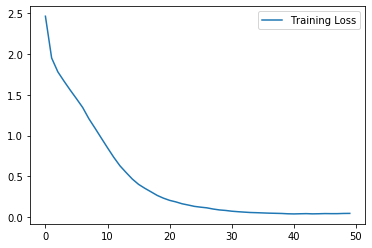

In [364]:
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.legend()
plt.show()

## Evaluate Model

In [365]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    s = preprocess_sentence(sentence)
    
    inputs = [inp_lang.word_index[c] for c in s.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    
    inputs = tf.convert_to_tensor(inputs)
    
    result= '<start> '
    
    hidden = init_hidden(1, gru_units)
    enc_out, enc_hidden = encoder((inputs, hidden))
    
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0) #(1, 1)
    
    for t in range(max_length_targ):
        preds, dec_hidden, attn_weights = decoder((dec_input, dec_hidden, enc_out))
        
        #attn_weights shape: (1, max_length_inp, 1)
        attn_weights = tf.reshape(attn_weights, shape=(-1, ))
        attention_plot[t] = attn_weights.numpy()
        
        #preds shape: (1, vocab_targ_size)
        predicted_id = tf.argmax(preds[0]).numpy()
        
        result += (targ_lang.index_word[predicted_id] + ' ')
        
        #Early exit if end token predicted
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        #The predicted word is fed back into the decoder
        dec_input = tf.expand_dims([predicted_id], 0)
        
    return result, sentence, attention_plot

In [366]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()

In [367]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [368]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: Help me!
Predicted translation: <start> مدد۔ <end> 


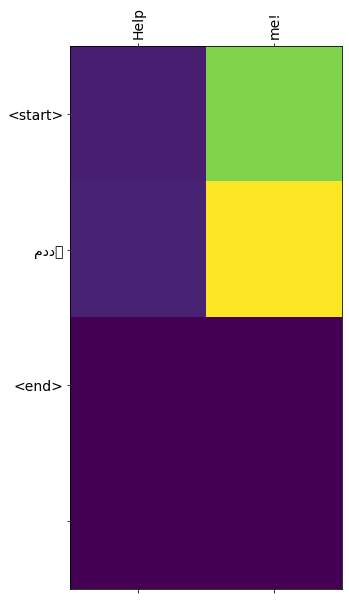

In [381]:
translate(u'Help me!')

Input: How are you?
Predicted translation: <start> تم کیسے کر رہے ہو ؟ <end> 


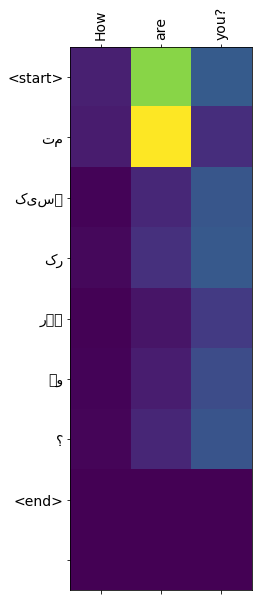

In [382]:
translate(u'How are you?')

Input: meet me.
Predicted translation: <start> تم نے ایک ارامدہ زندگی گزار رہا ہے۔ <end> 


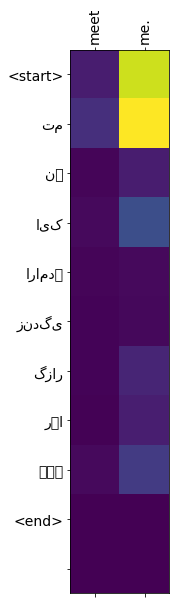

In [385]:
translate(u'meet me.')